# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

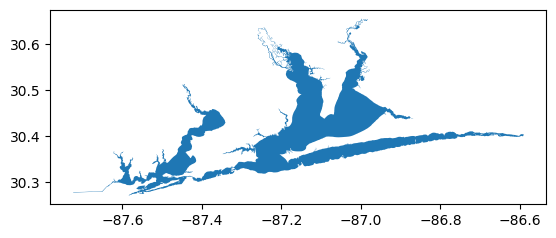

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2938, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:356: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  cond_notna = mask & (df_out["QA_flag"].notna())  # Mask cond and not NA
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version

In [11]:
location.harmonize_locations?

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2938, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

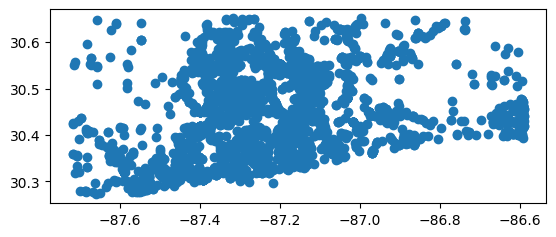

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

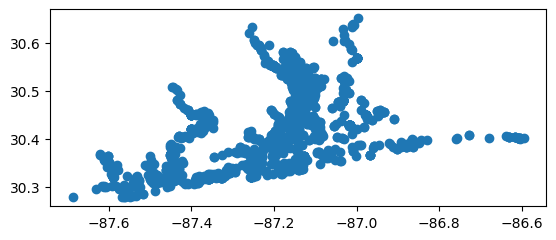

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1476

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,AWW_WQX,Alabama Water Watch,AWW_WQX-aww_0321:20131111121500:SR:WSO,2013-11-11,12:15:00,CST,AWW_WQX-aww_0321,STORET-1079479903,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027950424132,2013-04-24,09:01:00,EST,21FLSEAS_WQX-02SEAS795,STORET-310551339,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027400613134,2013-06-13,10:01:00,EST,21FLSEAS_WQX-02SEAS740,STORET-310489836,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,AWW_WQX,Alabama Water Watch,AWW_WQX-aww_0330:20130112134500:SR:WSO,2013-01-12,13:45:00,CST,AWW_WQX-aww_0330,STORET-1079461086,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463787,USGS-AL,USGS Alabama Water Science Center,nwisal.01.99900500,1999-03-02,14:20:00,CST,USGS-02376115,NWIS-104002666,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
463788,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00201479,2001-11-28,12:05:00,CST,USGS-02377570,NWIS-53918846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
463789,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202076,2001-10-03,16:40:00,CDT,USGS-02376115,NWIS-104000948,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
463790,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202072,2001-11-28,13:45:00,CST,USGS-02376115,NWIS-104000936,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

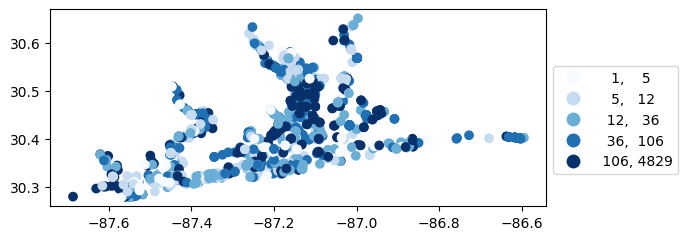

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ResultMeasureValue: "Not Reported" result cannot be used' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(2.0, 'meter')> <Quantity(0.94, 'meter')>
 <Quantity(0.6, 'meter')> ... <Quantity(1.67, 'meter')>
 <Quantity(0.3048, 'meter')> <Quantity(0.11, 'meter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    19538.000000
mean         1.166685
std          2.026694
min          0.000000
25%          0.600000
50%          1.000000
75%          1.400000
max        260.000000
dtype: float64
Unusable results: 88
Usable results with inferred units: 0
Results outside threshold (0.0 to 13.326848441851071): 1


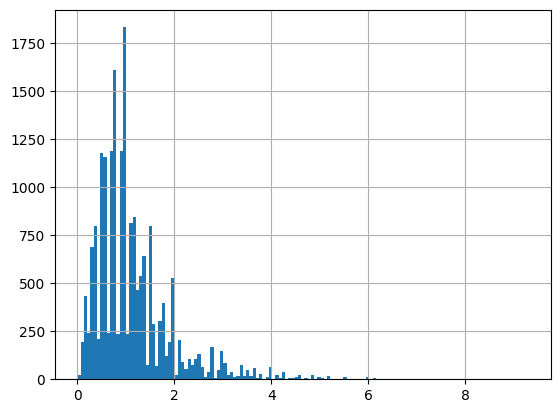

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
4,AWW_WQX-aww_0330,2,m,NaN,m,2.0 meter
99,21AWIC-7290,.94,m,NaN,m,0.94 meter
111,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
131,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
143,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
...,...,...,...,...,...,...
462944,21FLPNS_WQX-G4NW0441,0.8,m,NaN,m,0.8 meter
462972,21FLPNS_WQX-3302H32GS1,0.7925,m,NaN,m,0.7925 meter
462991,21FLESC_WQX-548AC-24Q4A,1.67,m,NaN,m,1.67 meter
462994,21FLPNS_WQX-3302J1GS7,0.3048,m,NaN,m,0.3048 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
125369,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125383,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125732,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125949,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127122,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
407611,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
454882,21FLKWAT_WQX-OKA-CB-BASS-2,Not Reported,ft,"ResultMeasureValue: ""Not Reported"" result cann...",ft,NaN
457948,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
458650,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
125369,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125383,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125732,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
125949,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127122,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
407611,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
454882,21FLKWAT_WQX-OKA-CB-BASS-2,Not Reported,ft,"ResultMeasureValue: ""Not Reported"" result cann...",ft,NaN
457948,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
458650,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,124,0.775726
4,21AWIC-1122,64,2.981156
...,...,...,...
1168,NARS_WQX-NCCA10-1432,1,1.075000
1169,NARS_WQX-NCCA10-1433,1,1.423333
1170,NARS_WQX-NCCA10-1434,1,2.400000
1171,NARS_WQX-NCCA10-1488,1,0.736667


<Axes: >

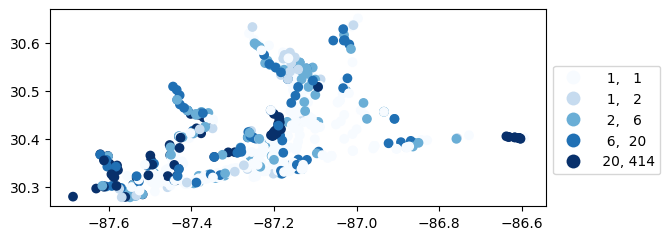

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

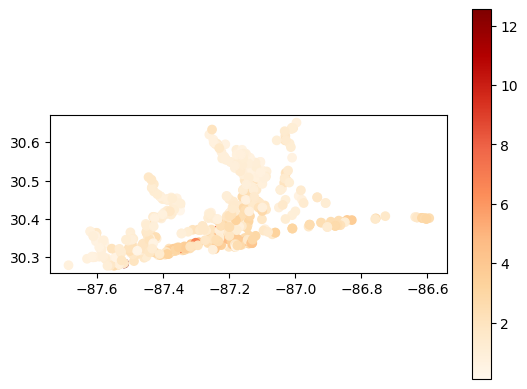

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(26.0555556, 'degree_Celsius')>
 <Quantity(12.35, 'degree_Celsius')> <Quantity(23.0, 'degree_Celsius')>
 ... <Quantity(25.0, 'degree_Celsius')> <Quantity(24.0, 'degree_Celsius')>
 <Quantity(20.5, 'degree_Celsius')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    94876.000000
mean        22.052807
std          9.858427
min        -12.944444
25%         17.100000
50%         22.300000
75%         27.200000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 81.20337055786025): 10


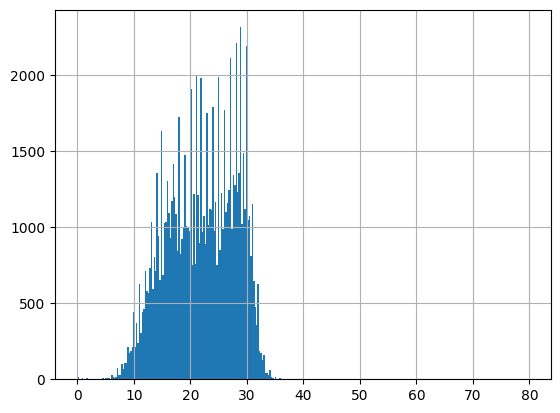

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
6,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
8,21FLPNS_WQX-33020J10,12.35,deg C,NaN,12.35 degree_Celsius,degC
19,AWW_WQX-aww_0318,23,deg C,NaN,23.0 degree_Celsius,degC
21,AWW_WQX-aww_1738,18.5,deg C,NaN,18.5 degree_Celsius,degC
27,21FLSEAS_WQX-02SEAS810,23,deg C,NaN,23.0 degree_Celsius,degC
...,...,...,...,...,...,...
463787,USGS-02376115,23.0,deg C,NaN,23.0 degree_Celsius,degC
463788,USGS-02377570,20.0,deg C,NaN,20.0 degree_Celsius,degC
463789,USGS-02376115,25.0,deg C,NaN,25.0 degree_Celsius,degC
463790,USGS-02376115,24.0,deg C,NaN,24.0 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
188676,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
255783,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
255788,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
256370,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
256371,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
256372,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
256373,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
257971,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC
258796,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
259895,21FLCBA-FWB01,71.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.2 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
59187,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
188676,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2544,UWFCEDB_WQX-SRC-AI31-22,19,21.900000
2545,UWFCEDB_WQX-SRC-AI36-22,26,21.957692
2546,UWFCEDB_WQX-SRC-AI42-22,21,22.590476
2547,UWFCEDB_WQX-SRC-AI44-22,24,21.095833


<Axes: >

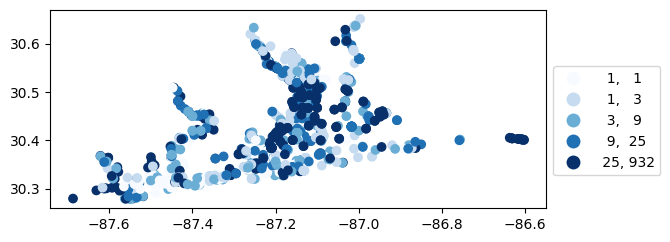

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

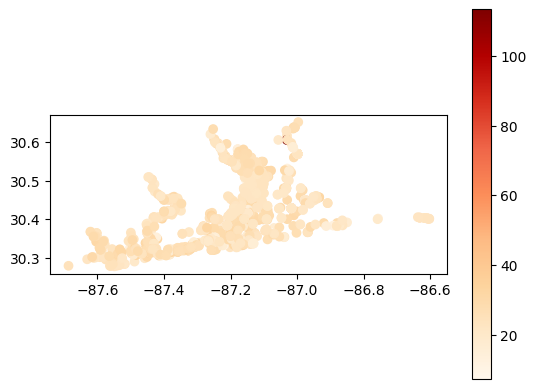

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(6.3, 'milligram / liter')> <Quantity(4.5, 'milligram / liter')>
 <Quantity(6.64, 'milligram / liter')> ...
 <Quantity(7.9, 'milligram / liter')> <Quantity(6.1, 'milligram / liter')>
 <Quantity(7.1, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
2,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
7,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
15,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
22,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
32,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
...,...,...,...,...,...
463664,21AWIC-942,2.2,mg/L,NaN,2.2 milligram / liter
463682,21AWIC-942,6.4,mg/L,NaN,6.4 milligram / liter
463688,21AWIC-942,7.9,mg/L,NaN,7.9 milligram / liter
463690,21AWIC-942,6.1,mg/L,NaN,6.1 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
2,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
7,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
15,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
22,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
32,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
...,...,...,...,...,...
463664,21AWIC-942,2.2,mg/L,NaN,2.2 milligram / liter
463682,21AWIC-942,6.4,mg/L,NaN,6.4 milligram / liter
463688,21AWIC-942,7.9,mg/L,NaN,7.9 milligram / liter
463690,21AWIC-942,6.1,mg/L,NaN,6.1 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
2154,UWFCEDB_WQX-SRC-AI31-22,38,3.760918
2155,UWFCEDB_WQX-SRC-AI36-22,52,3.514965
2156,UWFCEDB_WQX-SRC-AI42-22,42,3.704803
2157,UWFCEDB_WQX-SRC-AI44-22,48,3.798289


<Axes: >

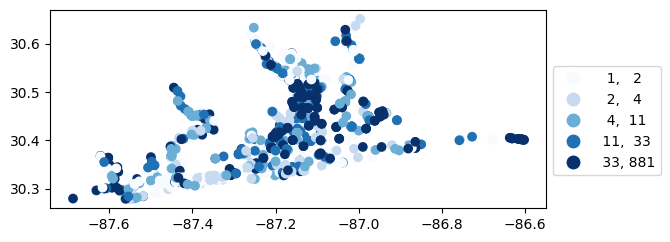

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

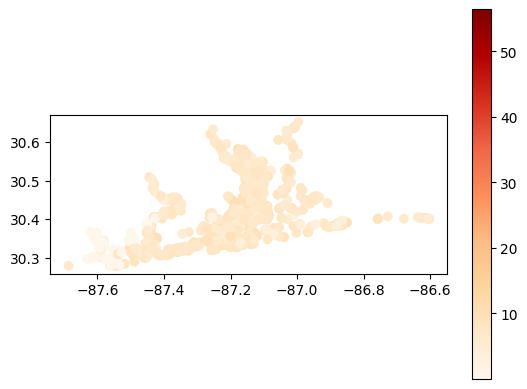

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.29, 'dimensionless')> <Quantity(8.09, 'dimensionless')>
 <Quantity(7.45, 'dimensionless')> ... <Quantity(8.27, 'dimensionless')>
 <Quantity(8.47, 'dimensionless')> <Quantity(8.48, 'dimensionless')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    59306.000000
mean         7.335854
std          0.904246
min          0.500000
25%          6.840000
50%          7.670000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 58285
Results outside threshold (0.0 to 12.761331276718863): 1


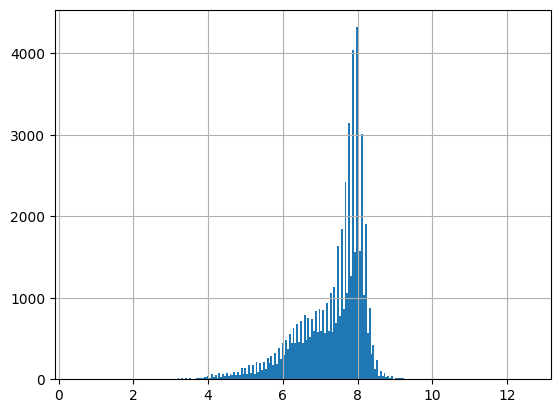

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
3,7.29,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.29 dimensionless
25,8.09,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.09 dimensionless
30,7.45,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.45 dimensionless
34,6.57,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.57 dimensionless
36,6.57,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.57 dimensionless
...,...,...,...,...
463749,7.25,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.25 dimensionless
463753,7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.0 dimensionless
463755,8.27,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.27 dimensionless
463756,8.47,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.47 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(1.012, 'Practical_Salinity_Units')>
 <Quantity(18.9, 'Practical_Salinity_Units')>
 <Quantity(25.0, 'Practical_Salinity_Units')> ...
 <Quantity(2.11, 'Practical_Salinity_Units')>
 <Quantity(1.89, 'Practical_Salinity_Units')>
 <Quantity(2.12, 'Practical_Salinity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    78437.000000
mean        15.734926
std        145.884705
min          0.000000
25%          5.800000
50%         16.000000
75%         23.100000
max      37782.000000
dtype: float64
Unusable results: 417
Usable results with inferred units: 10
Results outside threshold (0.0 to 891.0431563292491): 4


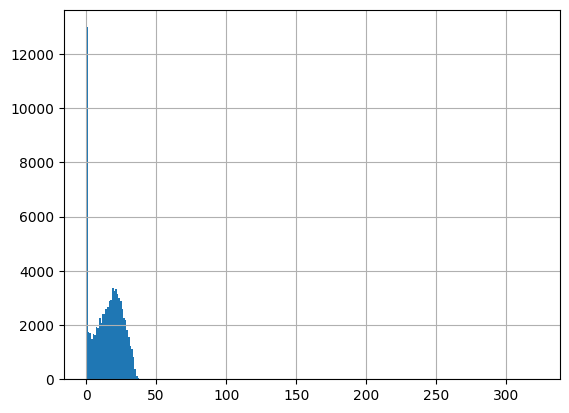

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
0,1.012,ppt,NaN,1.012 Practical_Salinity_Units
11,18.9,ppth,NaN,18.9 Practical_Salinity_Units
12,25,ppt,NaN,25.0 Practical_Salinity_Units
14,11.82,ppth,NaN,11.82 Practical_Salinity_Units
23,.03,ppt,NaN,0.03 Practical_Salinity_Units
...,...,...,...,...
463748,2.16,ppth,NaN,2.16 Practical_Salinity_Units
463750,2.07,ppth,NaN,2.07 Practical_Salinity_Units
463751,2.11,ppth,NaN,2.11 Practical_Salinity_Units
463754,1.89,ppth,NaN,1.89 Practical_Salinity_Units


###### Nitrogen

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'as N' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:484: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['as N' 'as N' 'as N' 'as N' nan 'as N' 'as N' nan nan nan nan 'as N' nan
 nan 'as N' nan 'as N' nan nan nan nan 'as N' 'as N' 'as N' 'as N' 'as N'
 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N'
 'as N' 'as N' 'as N' nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.3, 'milligram / liter')>
 <Quantity(0.36, 'milligram / liter')>
 <Quantity(0.33875, 'milligram / liter')>
 <Quantity(0.53125, 'milligram / liter')>
 <Quantity(135.0, 'milligram / liter')>
 <Quantity(0.4075, 'milligram / liter')>
 <Quantity(0.35375, 'milligram / liter')>
 <Quantity(27.5, 'milligram / liter')>
 <Quantity(82.4, 'milligram / liter')>
 <Quantity(51.9, 'milligram / liter')>
 <Quantity(11.8, 'milligram / liter')>
 <Quantity(0.495, 'milligram / liter')>
 <Quantity(131.0, 'milligram / liter')>
 <Quantity(1630.0, 'milligram / liter')>
 <Quantity(0.4475, 'milligram / liter')>
 <Quantity(23.5, 'milligram / liter')>
 <Quantity(0.36125, 'milligram / liter')>
 <Quantity(49.8, 'milligram / liter')>
 <Quantity(83.6, 'milligram / liter')>
 <Quantity(197

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtyp

-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.4665321860789): 1


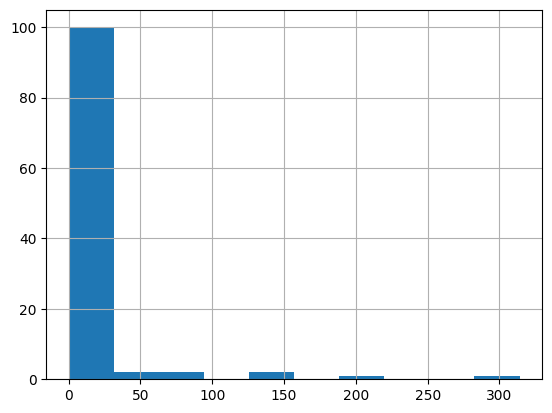

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
57346,0.3,mg/L,NaN,0.3 milligram / liter
57645,0.36,mg/L,NaN,0.36 milligram / liter
57756,0.33875,mg/L,NaN,0.33875 milligram / liter
57850,0.53125,mg/L,NaN,0.53125 milligram / liter
58524,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
463275,18.69,mg/l,NaN,18.69 milligram / liter
463282,16.18,mg/l,NaN,16.18 milligram / liter
463283,18.99,mg/l,NaN,18.99 milligram / liter
463286,18.72,mg/l,NaN,18.72 milligram / liter


###### Conductivity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(19204.2, 'microsiemens / centimeter')>
 <Quantity(222.3, 'microsiemens / centimeter')>
 <Quantity(102.8, 'microsiemens / centimeter')> ...
 <Quantity(110.0, 'microsiemens / centimeter')>
 <Quantity(390.0, 'microsiemens / centimeter')>
 <Quantity(65.0, 'microsiemens / centimeter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


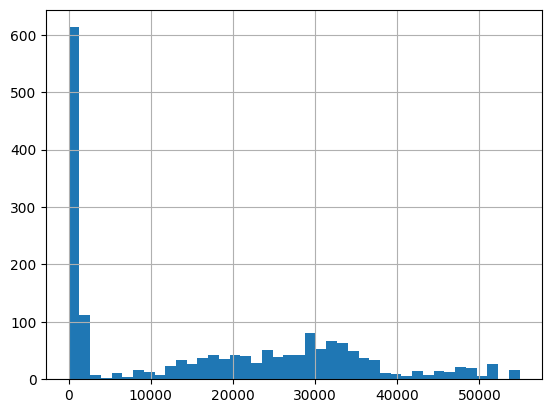

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
16,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
108,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
218,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
429,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
887,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
463674,110,umho/cm,NaN,110.0 microsiemens / centimeter
463679,65,umho/cm,NaN,65.0 microsiemens / centimeter
463681,110,umho/cm,NaN,110.0 microsiemens / centimeter
463684,390,umho/cm,NaN,390.0 microsiemens / centimeter


###### Chlorophyll a

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.0023, 'milligram / liter')>
 <Quantity(0.0029, 'milligram / liter')>
 <Quantity(0.0041, 'milligram / liter')> ...
 <Quantity(0.00672003521, 'milligram / liter')>
 <Quantity(0.00229276774, 'milligram / liter')>
 <Quantity(0.00500738688, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    9463.000000
mean        1.145369
std         1.199165
min        -0.840000
25%         0.007410
50%         0.940000
75%         1.820000
max         9.990000
dtype: float64
Unusable results: 628
Usable results with inferred units: 6175
Results outside threshold (0.0 to 8.34036041607418): 8


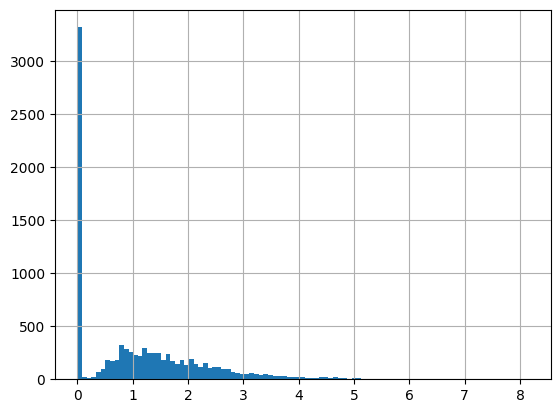

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
277,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
618,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
736,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1351,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1519,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
462667,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
462752,9.43660497156775,ug/L,NaN,0.00943660497156775 milligram / liter
462949,6.72003521191891,ug/L,NaN,0.0067200352119189104 milligram / liter
462950,2.29276774101202,ug/L,NaN,0.00229276774101202 milligram / liter


###### Organic Carbon

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(5.4, 'milligram / liter')> <Quantity(2.6, 'milligram / liter')>
 <Quantity(3.9, 'milligram / liter')> ...
 <Quantity(0.5, 'milligram / liter')> <Quantity(1.7, 'milligram / liter')>
 <Quantity(1.5, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count      5087.000000
mean       1080.215152
std       11291.424197
min           0.000000
25%           2.700000
50%           4.300000
75%           8.200000
max      410000.000000
dtype: float64
Unusable results: 165
Usable results with inferred units: 0
Results outside threshold (0.0 to 68828.76033254946): 22


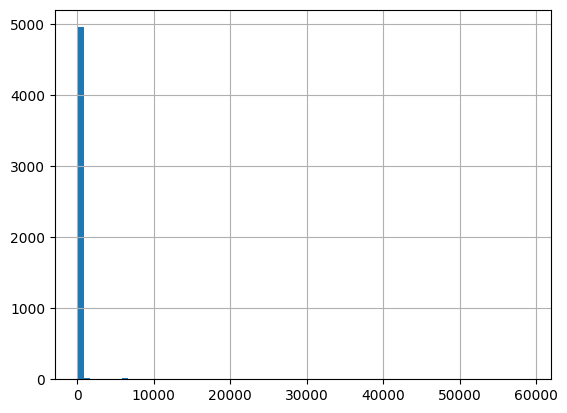

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
140,5.4,mg/L,NaN,5.4 milligram / liter
142,2.6,mg/L,NaN,2.6 milligram / liter
178,3.9,mg/L,NaN,3.9 milligram / liter
236,5.2,mg/L,NaN,5.2 milligram / liter
296,6.0,mg/L,NaN,6.0 milligram / liter
...,...,...,...,...
463319,1.5,mg/l,NaN,1.5 milligram / liter
463323,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
463324,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
463337,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Turbidity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(380.4523, 'Nephelometric_Turbidity_Units')>
 <Quantity(0.0, 'Nephelometric_Turbidity_Units')>
 <Quantity(190.2023, 'Nephelometric_Turbidity_Units')> ...
 <Quantity(1.2, 'Nephelometric_Turbidity_Units')>
 <Quantity(5.0, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.5, 'Nephelometric_Turbidity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    47789.000000
mean        30.348489
std        205.798956
min         -0.840000
25%          1.600000
50%          3.000000
75%          7.560000
max      32342.452300
dtype: float64
Unusable results: 610
Usable results with inferred units: 10
Results outside threshold (0.0 to 1265.142224924023): 65


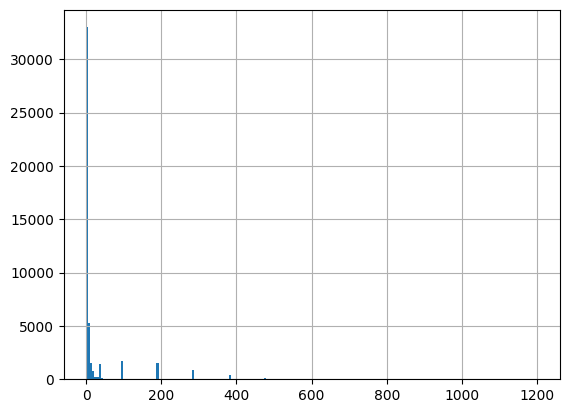

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
20,20,JTU,NaN,380.4523 Nephelometric_Turbidity_Units
33,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
46,10,JTU,NaN,190.2023 Nephelometric_Turbidity_Units
56,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
62,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
...,...,...,...,...
463671,1.5,NTU,NaN,1.5 Nephelometric_Turbidity_Units
463672,1,NTU,NaN,1.0 Nephelometric_Turbidity_Units
463675,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
463676,5,NTU,NaN,5.0 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.061, 'milligram / liter')>
 <Quantity(0.03, 'milligram / liter')>
 <Quantity(0.13, 'milligram / liter')> ...
 <Quantity(0.16, 'milligram / liter')>
 <Quantity(0.18, 'milligram / liter')>
 <Quantity(0.31, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
45,.061,mg/L,NaN,NaN
79,0.03,mg/L,NaN,NaN
174,.13,mg/L,NaN,NaN
203,0.003,mg/L,NaN,NaN
355,0.002,mg/L,NaN,NaN
...,...,...,...,...
463643,.18,mg/L,NaN,NaN
463652,.25,mg/L,NaN,NaN
463666,.16,mg/L,NaN,NaN
463669,.18,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
45,.061,mg/L,NaN,NaN
79,0.03,mg/L,NaN,NaN
174,.13,mg/L,NaN,NaN
203,0.003,mg/L,NaN,NaN
355,0.002,mg/L,NaN,NaN
...,...,...,...,...
463215,0.020,mg/l as P,NaN,NaN
463219,1.43,mg/l as P,NaN,NaN
463225,0.08,mg/l as P,NaN,NaN
463232,0.05,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
4208,0.019,mg/L,NaN,0.019 milligram / liter
9433,0.002,mg/L,NaN,0.002 milligram / liter
15788,0.003,mg/L,NaN,0.003 milligram / liter
19109,0.019,mg/L,NaN,0.019 milligram / liter
51079,0.002,mg/L,NaN,0.002 milligram / liter
53187,0.017,mg/L,NaN,0.017 milligram / liter
68332,0.021,mg/L,NaN,0.021 milligram / liter
71412,0.003,mg/L,NaN,0.003 milligram / liter
78901,0.020,mg/L,NaN,0.02 milligram / liter
85309,0.002,mg/L,NaN,0.002 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
27883,.5,mg/L,NaN,NaN
27968,.036,mg/L,NaN,NaN
29478,.089,mg/L,NaN,NaN
30557,.017,mg/L,NaN,NaN
31832,.035,mg/L,NaN,NaN
...,...,...,...,...
463643,.18,mg/L,NaN,NaN
463652,.25,mg/L,NaN,NaN
463666,.16,mg/L,NaN,NaN
463669,.18,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40585
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


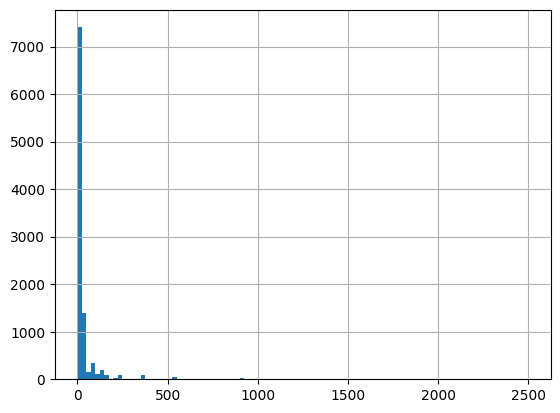

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
1,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
5,80,cfu/100mL,NaN,NaN
9,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
10,2,MPN/100mL,NaN,NaN
13,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
...,...,...,...,...
463515,194,cfu/100mL,NaN,NaN
463521,226,cfu/100mL,NaN,NaN
463534,145,cfu/100mL,NaN,NaN
463560,317,cfu/100mL,NaN,NaN


###### Escherichia coli

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan <Quantity(12.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(6.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a 

-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 11973
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


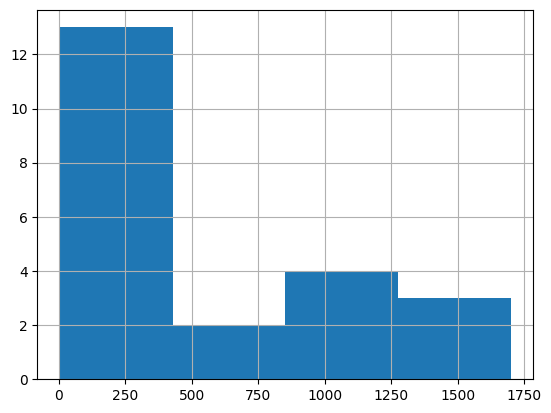

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
26,0,cfu/100mL,NaN,NaN
40,0,cfu/100mL,NaN,NaN
76,1000,cfu/100mL,NaN,NaN
82,33.3333333333333,cfu/100mL,NaN,NaN
87,0,cfu/100mL,NaN,NaN
...,...,...,...,...
463280,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
463293,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
463299,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
463339,12,cfu/100ml,NaN,12.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 78437 
Mean: 15.734925708531076 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
14252,15030,ppt,NaN,15030.0 Practical_Salinity_Units
24425,322,ppth,NaN,322.0 Practical_Salinity_Units
56791,2150,ppth,NaN,2150.0 Practical_Salinity_Units
100135,37782,ppth,NaN,37782.0 Practical_Salinity_Units
170235,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
1323,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
2462,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3981,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
4348,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
4565,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
459487,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
459497,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
459647,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
459675,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

16        19204.2 microsiemens / centimeter
108         222.3 microsiemens / centimeter
218         102.8 microsiemens / centimeter
429       11017.5 microsiemens / centimeter
887          32.0 microsiemens / centimeter
                        ...                
463674      110.0 microsiemens / centimeter
463679       65.0 microsiemens / centimeter
463681      110.0 microsiemens / centimeter
463684      390.0 microsiemens / centimeter
463687       65.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
155203,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
158906,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
151458,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
157517,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
150769,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
108539,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
170368,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
67166,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
41190,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
155203,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
158906,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
151458,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
157517,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
150769,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
108539,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
170368,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
67166,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
41190,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

155203    36.356 dimensionless
158906    36.345 dimensionless
151458    36.338 dimensionless
157517    36.336 dimensionless
150769     36.33 dimensionless
                  ...         
108539     0.013 dimensionless
170368     0.012 dimensionless
67166      0.012 dimensionless
41190      0.012 dimensionless
171757     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
155203,2007-08-09,12:15:00,CST
158906,2007-08-09,12:15:00,CST
151458,2007-08-09,12:15:00,CST
157517,2007-08-09,12:15:00,CST
150769,2007-08-09,12:15:00,CST
...,...,...,...
463787,1999-03-02,14:20:00,CST
463788,2001-11-28,12:05:00,CST
463789,2001-10-03,16:40:00,CDT
463790,2001-11-28,13:45:00,CST


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

,ActivityStartDate,Activity_datetime
155203,2007-08-09,2007-08-09 18:15:00+00:00
158906,2007-08-09,2007-08-09 18:15:00+00:00
151458,2007-08-09,2007-08-09 18:15:00+00:00
157517,2007-08-09,2007-08-09 18:15:00+00:00
150769,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
463787,1999-03-02,1999-03-02 20:20:00+00:00
463788,2001-11-28,2001-11-28 18:05:00+00:00
463789,2001-10-03,2001-10-03 21:40:00+00:00
463790,2001-11-28,2001-11-28 19:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

1786       7.0
4191       7.0
68241      0.1
68328      2.2
68462      2.0
          ... 
78547      2.2
110413     1.0
111001    16.0
111478    16.0
169725    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Turbidity,QA_DO,QA_Temperature,QA_Carbon,QA_Conductivity,QA_Salinity,QA_Fecal_Coliform,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus
155203,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,CST,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158906,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,CST,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151458,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,CST,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157517,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,CST,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150769,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,CST,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463787,USGS-AL,USGS Alabama Water Science Center,nwisal.01.99900500,1999-03-02,14:20:00,CST,USGS-02376115,NWIS-104002666,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463788,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00201479,2001-11-28,12:05:00,CST,USGS-02377570,NWIS-53918846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463789,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202076,2001-10-03,16:40:00,CDT,USGS-02376115,NWIS-104000948,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463790,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202072,2001-11-28,13:45:00,CST,USGS-02376115,NWIS-104000936,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

54852 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Nitrogen', 'QA_Chlorophyll',
       'QA_Secchi', 'QA_pH', 'QA_E_coli', 'QA_Turbidity', 'QA_DO',
       'QA_Temperature', 'QA_Carbon', 'QA_Conductivity', 'QA_Salinity',
       'QA_Fecal_Coliform', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Turbidity,QA_DO,QA_Temperature,QA_Carbon,QA_Conductivity,QA_Salinity,QA_Fecal_Coliform,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus
155203,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158906,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151458,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157517,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150769,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Secchi',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Conductivity',
 'QA_Fecal_Coliform',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus']

<Axes: >

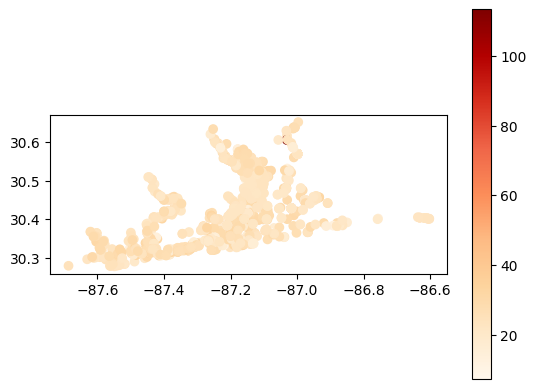

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)